<a href="https://colab.research.google.com/github/dieegogutierrez/SpaceRaceAnalysis/blob/main/Space_Missions_Analysis_(start).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

<center><img src="https://i.imgur.com/9hLRsjZ.jpg" height=400></center>

This dataset was scraped from [nextspaceflight.com](https://nextspaceflight.com/launches/past/?page=1) and includes all the space missions since the beginning of Space Race between the USA and the Soviet Union in 1957!

### Install Package with Country Codes

In [173]:
%pip install iso3166

### Upgrade Plotly

Run the cell below if you are working with Google Colab.

In [174]:
%pip install --upgrade plotly

### Import Statements

In [175]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

# These might be helpful:
from iso3166 import countries
from datetime import datetime, timedelta

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Notebook Presentation

In [176]:
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

In [177]:
df_data = pd.read_csv('/content/drive/MyDrive/Space+Missions+(start)/mission_launches_updated_2023-08-03.csv')

# Preliminary Data Exploration

* What is the shape of `df_data`?
* How many rows and columns does it have?
* What are the column names?
* Are there any NaN values or duplicates?

In [178]:
df_data.shape

(6574, 8)

In [179]:
df_data.columns

Index(['Unnamed: 0', 'Organization', 'Location', 'Datetime', 'Details',
       'Status', 'Price', 'Mission_status'],
      dtype='object')

## Data Cleaning - Check for Missing Values and Duplicates

Consider removing columns containing junk data.

In [180]:
df_data.duplicated().any()

False

In [181]:
df_data.isna().any()

Unnamed: 0        False
Organization      False
Location          False
Datetime          False
Details           False
Status            False
Price              True
Mission_status    False
dtype: bool

In [182]:
df_data.drop('Unnamed: 0', axis=1, inplace=True)

In [183]:
df_data['Datetime'] = pd.to_datetime(df_data['Datetime'], utc=True).dt.tz_localize(None)

## Descriptive Statistics

In [184]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Organization    6574 non-null   object        
 1   Location        6574 non-null   object        
 2   Datetime        6574 non-null   datetime64[ns]
 3   Details         6574 non-null   object        
 4   Status          6574 non-null   object        
 5   Price           2528 non-null   float64       
 6   Mission_status  6574 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 359.6+ KB


In [185]:
df_data.describe()

,Price
count,"2,528.00"
mean,70.06
std,103.34
min,2.50
25%,20.00
50%,29.75
75%,67.00
max,876.00


# Number of Launches per Company

Create a chart that shows the number of space mission launches by organisation.

In [186]:
launches_by_organization = df_data.groupby('Organization').size().sort_values()

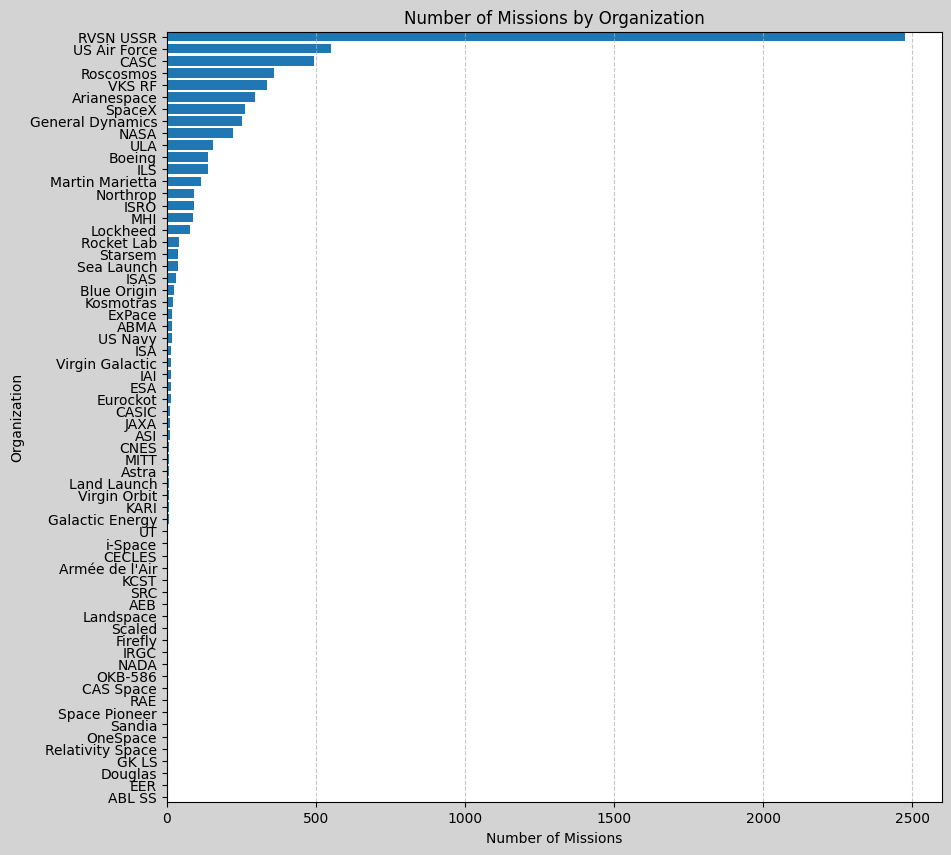

In [187]:
plt.figure(figsize=(10, 10), facecolor='lightgray')
plt.barh(launches_by_organization.index, launches_by_organization.values)
plt.xlabel('Number of Missions')
plt.ylabel('Organization')
plt.title('Number of Missions by Organization')
plt.margins(y=0)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Number of Active versus Retired Rockets

How many rockets are active compared to those that are decomissioned?

In [188]:
df_data['Status'].value_counts()

Retired    5244
Active     1330
Name: Status, dtype: int64

# Distribution of Mission Status

How many missions were successful?
How many missions failed?

In [189]:
df_data['Mission_status'].value_counts()

Success              5914
Failure               444
Partial Failure       107
Suborbital            102
Prelaunch Failure       7
Name: Mission_status, dtype: int64

# How Expensive are the Launches?

Create a histogram and visualise the distribution. The price column is given in USD millions (careful of missing values).

In [190]:
df_data_clean = df_data.dropna()
df_price = df_data_clean['Price']

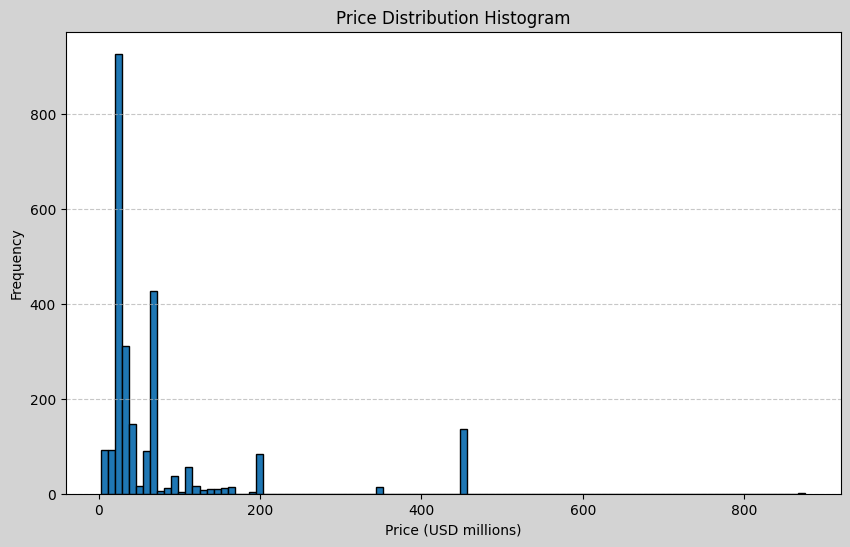

In [191]:
plt.figure(figsize=(10, 6), facecolor='lightgray')
plt.hist(df_price.values, bins=100, edgecolor='black')
plt.xlabel('Price (USD millions)')
plt.ylabel('Frequency')
plt.title('Price Distribution Histogram')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Use a Choropleth Map to Show the Number of Launches by Country

* Create a choropleth map using [the plotly documentation](https://plotly.com/python/choropleth-maps/)
* Experiment with [plotly's available colours](https://plotly.com/python/builtin-colorscales/). I quite like the sequential colour `matter` on this map.
* You'll need to extract a `country` feature as well as change the country names that no longer exist.

Wrangle the Country Names

You'll need to use a 3 letter country code for each country. You might have to change some country names.

* Russia is the Russian Federation
* New Mexico should be USA
* Yellow Sea refers to China
* Shahrud Missile Test Site should be Iran
* Pacific Missile Range Facility should be USA
* Barents Sea should be Russian Federation
* Gran Canaria should be USA


You can use the iso3166 package to convert the country names to Alpha3 format.

In [192]:
df_data['Country'] = df_data['Location'].str.split(', ').str[-1]
update = {
    'Russia': 'Russian Federation',
    'New Mexico': 'USA',
    'Yellow Sea': 'China',
    'Shahrud Missile Test Site': 'Iran',
    'Pacific Missile Range Facility': 'USA',
    'Barents Sea': 'Russian Federation',
    'Gran Canaria': 'USA',
    'Marshall Islands': 'USA',
    'Iran': 'Iran, Islamic Republic of',
    'North Korea': "Korea, Democratic People's Republic of",
    'South Korea': "Korea, Republic of",
    'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland',
    'Pacific Ocean': 'USA'
}
df_data['Country'] = df_data['Country'].replace(update)
df_data['Country Code'] = df_data['Country'].apply(lambda x: (countries.get(x).alpha3))
launches_by_country = df_data.groupby(['Country', 'Country Code']).size().reset_index(name='Launch Count')

In [193]:
fig = px.choropleth(
    launches_by_country,
    locations="Country Code",
    color="Launch Count",
    hover_name="Country",
    color_continuous_scale='matter',
)
fig.show()

# Use a Choropleth Map to Show the Number of Failures by Country


In [194]:
failures_by_country = df_data[df_data['Mission_status'] == 'Failure']
failures_by_country = failures_by_country.groupby(['Country', 'Country Code']).size().reset_index(name='Failure Count')

In [195]:
fig = px.choropleth(
    failures_by_country,
    locations="Country Code",
    color="Failure Count",
    hover_name="Country",
    color_continuous_scale='plasma',
)
fig.show()

# Create a Plotly Sunburst Chart of the countries, organisations, and mission status.

In [196]:
fig = px.sunburst(df_data,
                  path=['Country Code', 'Organization', 'Mission_status'],
                  hover_data=['Country'],
                  color_continuous_scale='viridis',
)
fig.show()

# Analyse the Total Amount of Money Spent by Organisation on Space Missions

In [197]:
money_spent_by_organization = df_data.dropna().groupby('Organization')['Price'].sum().sort_values(ascending=False)

In [198]:
money_spent_by_organization

Organization
NASA               62,076.00
Arianespace        18,883.00
ULA                17,610.00
SpaceX             16,682.00
CASC               15,089.84
RVSN USSR          14,200.00
Roscosmos           6,512.44
ILS                 5,610.00
Northrop            4,520.00
MHI                 3,762.50
VKS RF              3,310.94
ISRO                2,582.00
US Air Force        1,550.92
Boeing              1,241.00
Martin Marietta       721.40
Starsem               718.00
Kosmotras             638.00
Lockheed              280.00
Rocket Lab            270.00
JAXA                  246.00
Eurockot              169.00
ExPace                149.40
Virgin Orbit           72.00
ESA                    37.00
Firefly                30.00
Galactic Energy        29.40
CASIC                  29.00
GK LS                  23.00
EER                    20.00
Astra                  17.50
Sandia                 15.00
Relativity Space       12.00
ABL SS                 12.00
Name: Price, dtype: float64

# Analyse the Amount of Money Spent by Organisation per Launch

In [199]:
money_spent_by_organization_per_launch = pd.concat([money_spent_by_organization, launches_by_organization], axis=1).reset_index()
money_spent_by_organization_per_launch.columns = ['Organization', 'Money Spent', 'Launch Count']
money_spent_by_organization_per_launch['Money per Launch'] = money_spent_by_organization_per_launch['Money Spent'] / money_spent_by_organization_per_launch['Launch Count']
money_spent_by_organization_per_launch = money_spent_by_organization_per_launch.sort_values('Money per Launch', ascending=False).dropna()

In [200]:
money_spent_by_organization_per_launch

,Organization,Money Spent,Launch Count,Money per Launch
0,NASA,"62,076.00",222,279.62
2,ULA,"17,610.00",156,112.88
1,Arianespace,"18,883.00",296,63.79
3,SpaceX,"16,682.00",262,63.67
8,Northrop,"4,520.00",91,49.67
9,MHI,"3,762.50",86,43.75
7,ILS,"5,610.00",137,40.95
4,CASC,"15,089.84",494,30.55
16,Kosmotras,638.00,22,29.00
11,ISRO,"2,582.00",90,28.69


# Chart the Number of Launches per Year

In [201]:
launches_per_year = df_data.groupby(df_data['Datetime'].dt.year).size()

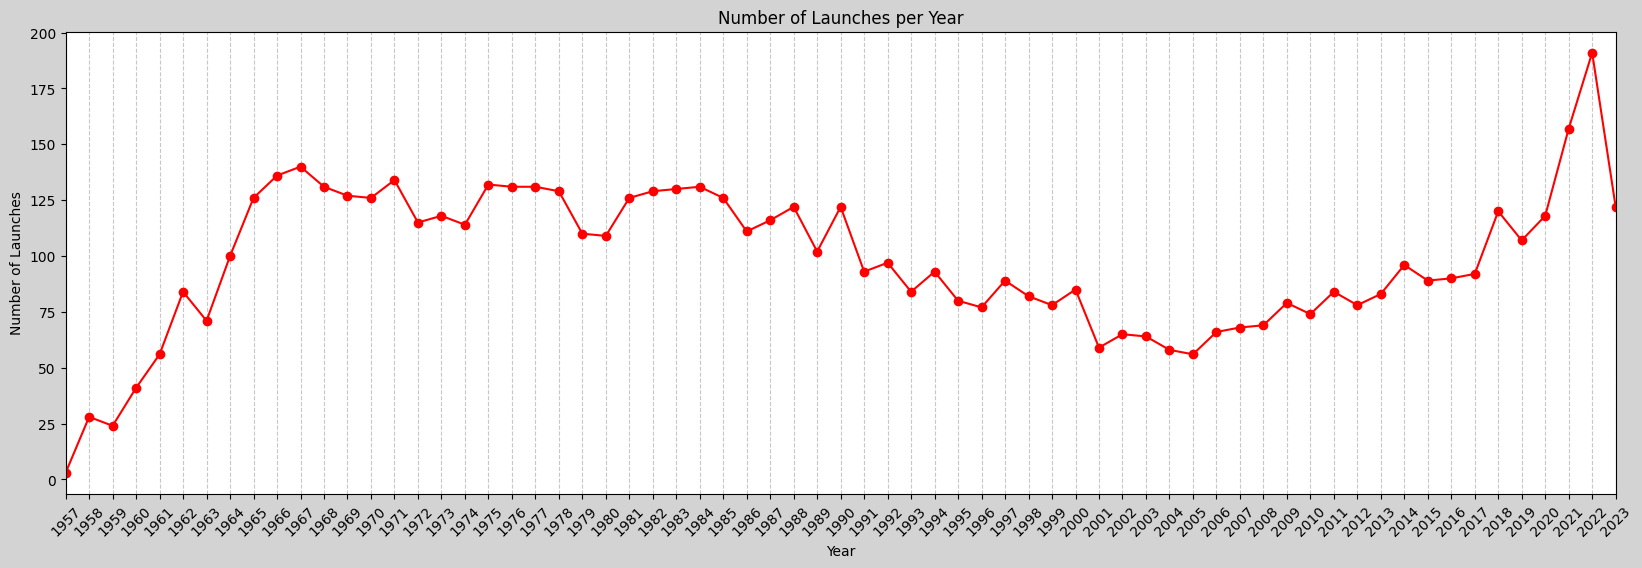

In [202]:
plt.figure(figsize=(20, 6), facecolor='lightgray')
plt.plot(launches_per_year, marker='o', linestyle='-', color='red')
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.title('Number of Launches per Year')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(launches_per_year.index, rotation=45)
plt.margins(x=0)

plt.show()

# Chart the Number of Launches Month-on-Month until the Present

Which month has seen the highest number of launches in all time? Superimpose a rolling average on the month on month time series chart.

In [203]:
launches_month_on_month = df_data.groupby('Datetime').size().reset_index(name='Launch Count')
launches_month_on_month = launches_month_on_month.groupby([launches_month_on_month['Datetime'].dt.month.rename('Month'), launches_month_on_month['Datetime'].dt.day.rename('Day')])['Launch Count'].sum().reset_index(name='Launch Count')
launches_month_on_month['Rolling Average'] = launches_month_on_month['Launch Count'].rolling(30).mean()
launches_month_on_month['Year'] = '2020'
launches_month_on_month['Date'] = pd.to_datetime(launches_month_on_month[['Year', 'Month', 'Day']])

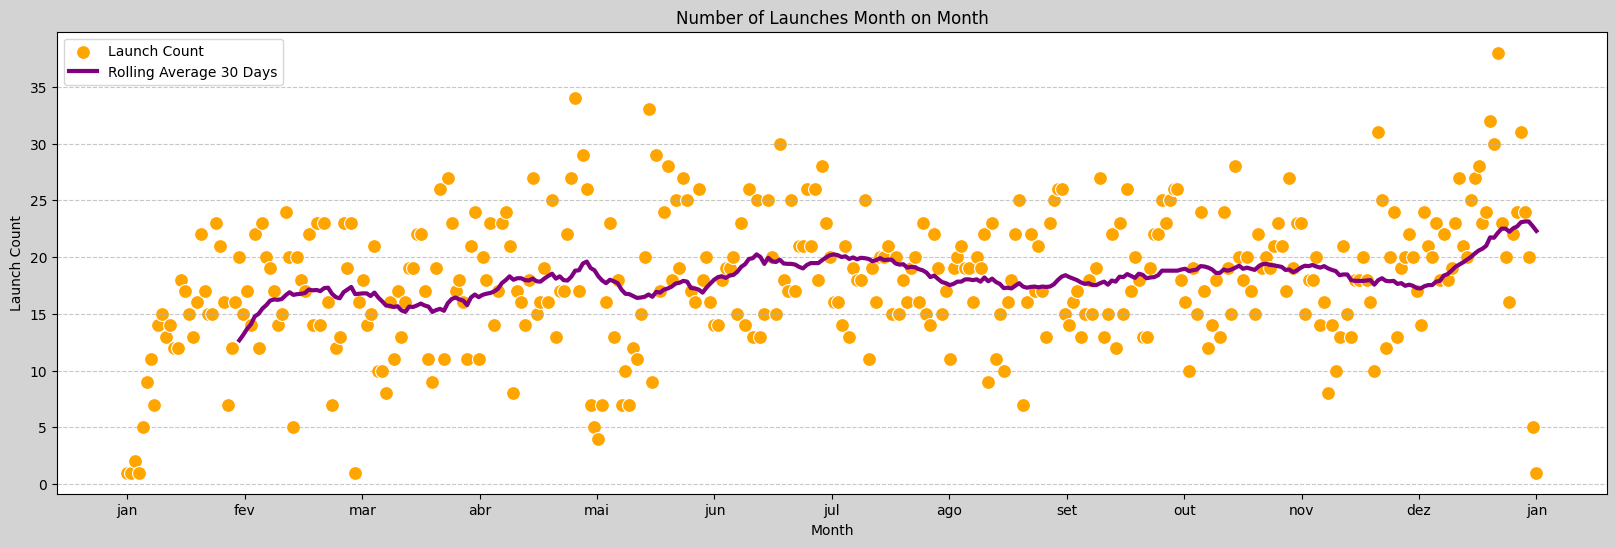

In [204]:
min_date = launches_month_on_month['Date'].min()
max_date = launches_month_on_month['Date'].max()
total_days = (max_date - min_date).days
monthly_intervals = [min_date + timedelta(days=total_days/12 * i) for i in range(13)]
month_labels = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez', 'jan']

plt.figure(figsize=(20, 6), facecolor='lightgray')

ax = sns.scatterplot(
      x = 'Date',
			y = 'Launch Count',
			data = launches_month_on_month,
      label = 'Launch Count',
      color = 'orange',
      marker = 'o',
      s = 100
)
sns.lineplot(
      x = 'Date',
			y = 'Rolling Average',
			data = launches_month_on_month,
      label = 'Rolling Average 30 Days',
      color = 'purple',
      linewidth = 3,
)
plt.xlabel('Month')
plt.ylabel('Launch Count')
plt.title('Number of Launches Month on Month')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ticks=monthly_intervals, labels=month_labels)
plt.legend(loc='upper left')

plt.show()

# Launches per Month: Which months are most popular and least popular for launches?

Some months have better weather than others. Which time of year seems to be best for space missions?

In [205]:
launches_month_on_month.groupby('Month')['Launch Count'].sum()

Month
1     395
2     487
3     517
4     571
5     535
6     599
7     551
8     563
9     567
10    588
11    518
12    683
Name: Launch Count, dtype: int64

# How has the Launch Price varied Over Time?

Create a line chart that shows the average price of rocket launches over time.

In [206]:
average_launch_price = df_data_clean.groupby(df_data_clean['Datetime'].dt.year)['Price'].mean()

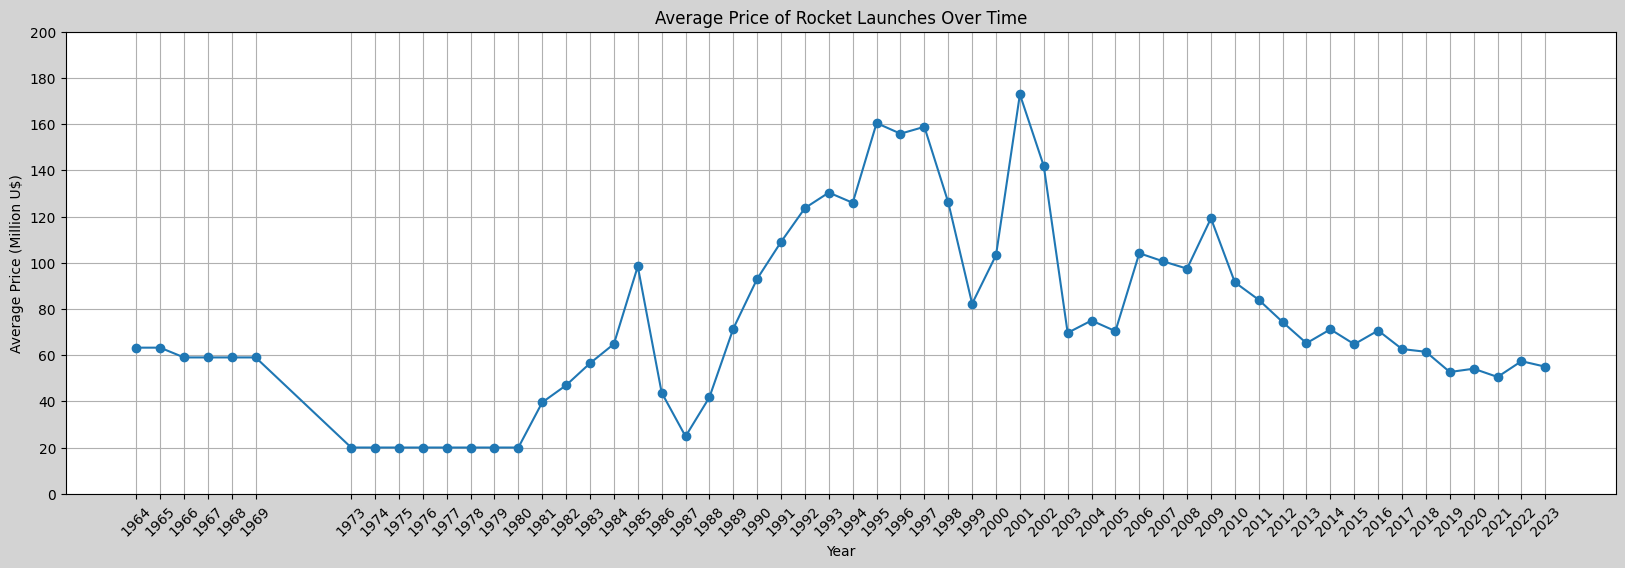

In [207]:
plt.figure(figsize=(20, 6), facecolor='lightgray')
plt.plot(average_launch_price.index, average_launch_price.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Price (Million U$)')
plt.title('Average Price of Rocket Launches Over Time')
plt.grid(True)
plt.xticks(average_launch_price.index, rotation=45)
plt.yticks(range(0, 201, 20))
plt.show()

# Chart the Number of Launches over Time by the Top 10 Organisations.

How has the dominance of launches changed over time between the different players?

In [208]:
launches_top10_organizations = df_data.groupby([df_data['Datetime'].dt.year.rename('Year'), 'Organization']).size().reset_index(name='Launch Count')
top10_organizations = launches_top10_organizations.groupby('Organization')['Launch Count'].sum().sort_values(ascending=False).head(10).reset_index()
launches_top10_organizations = launches_top10_organizations.merge(top10_organizations['Organization'], on='Organization', how='inner')

In [209]:
fig = px.bar(launches_top10_organizations, x="Year", y="Launch Count", color="Organization")
fig.update_layout(title="Number of Launches over Time by Top 10 Organizations")
fig.show()

# Cold War Space Race: USA vs USSR

The cold war lasted from the start of the dataset up until 1991.

In [210]:
cold_war_update = {
    'Russian Federation': 'USSR',
    'Kazakhstan': 'USSR'
}
df_data.loc[(df_data['Datetime'].dt.year <= 1991), 'Country'] = df_data['Country'].replace(cold_war_update)

In [211]:
cold_war = df_data[df_data['Datetime'].dt.year <= 1991]
cold_war_launches = cold_war.groupby([cold_war['Datetime'].dt.year.rename('Year'), 'Country']).size().reset_index(name='Launch Count')

## Create a Plotly Pie Chart comparing the total number of launches of the USSR and the USA

Hint: Remember to include former Soviet Republics like Kazakhstan when analysing the total number of launches.

In [212]:
cold_war_launches_USA_USSR = cold_war_launches.loc[cold_war_launches['Country'].isin(['USA', 'USSR'])]

In [213]:
fig = px.pie(cold_war_launches_USA_USSR, values="Launch Count", names="Country", title='Cold War Space Race Total Rocket Launches')
fig.show()

## Create a Chart that Shows the Total Number of Launches Year-On-Year by the Two Superpowers

In [214]:
fig = px.bar(cold_war_launches_USA_USSR, x="Year", y="Launch Count", color='Country', barmode='group', title='Total Number of Launches Year-On-Year')
fig.update_xaxes(dtick=1)
fig.show()

## Chart the Total Number of Mission Failures Year on Year.

In [215]:
mission_status_year_on_year = df_data.groupby(df_data['Datetime'].dt.year.rename('Year'))['Mission_status'].value_counts().reset_index(name='Total')
mission_failures_year_on_year = mission_status_year_on_year[mission_status_year_on_year['Mission_status'] == 'Failure']

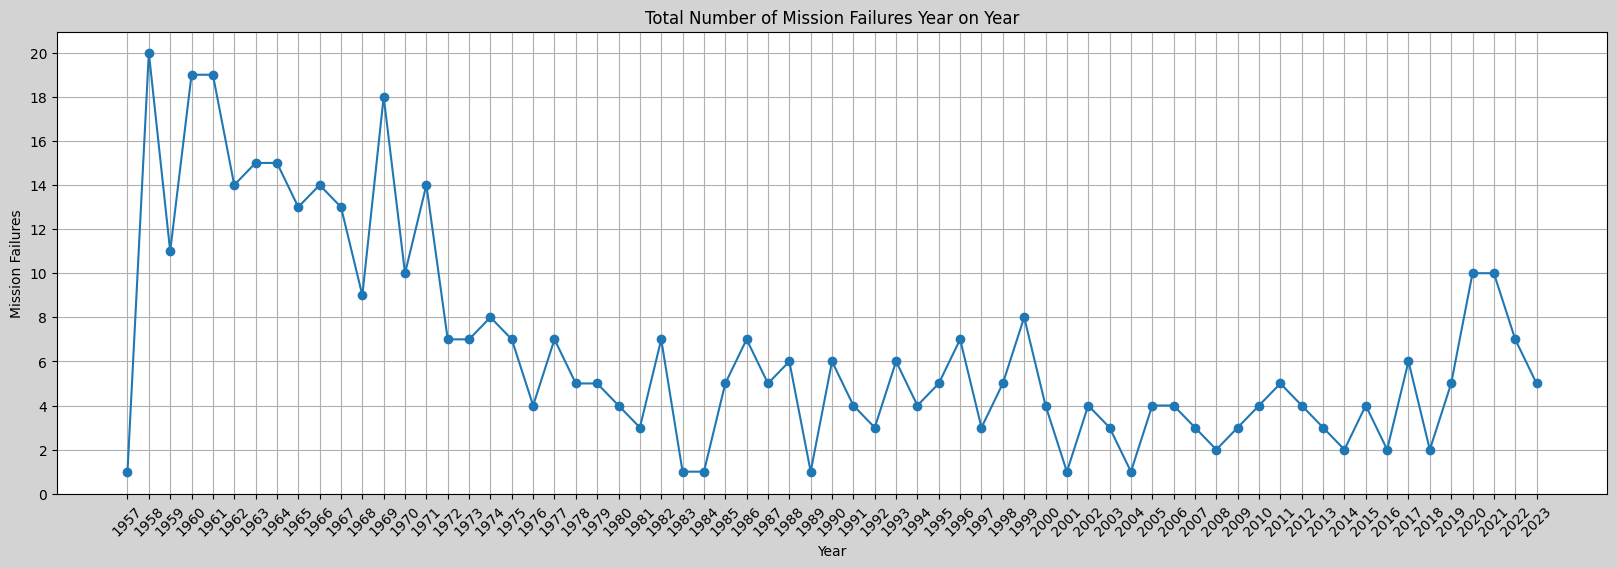

In [216]:
plt.figure(figsize=(20, 6), facecolor='lightgray')
plt.plot(mission_failures_year_on_year['Year'], mission_failures_year_on_year['Total'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Mission Failures')
plt.title('Total Number of Mission Failures Year on Year')
plt.xticks(mission_failures_year_on_year['Year'], rotation=45)
plt.yticks(range(0, 21, 2))
plt.grid(True)
plt.show()

## Chart the Percentage of Failures over Time

Did failures go up or down over time? Did the countries get better at minimising risk and improving their chances of success over time?

In [217]:
total_mission_status_year_on_year = mission_status_year_on_year.groupby(['Year'])['Total'].sum().reset_index(name='Total Missions')
mission_failures_year_on_year_percentage = mission_failures_year_on_year.merge(total_mission_status_year_on_year, on='Year')
mission_failures_year_on_year_percentage['Percentage'] = (mission_failures_year_on_year_percentage['Total'] / mission_failures_year_on_year_percentage['Total Missions']) * 100

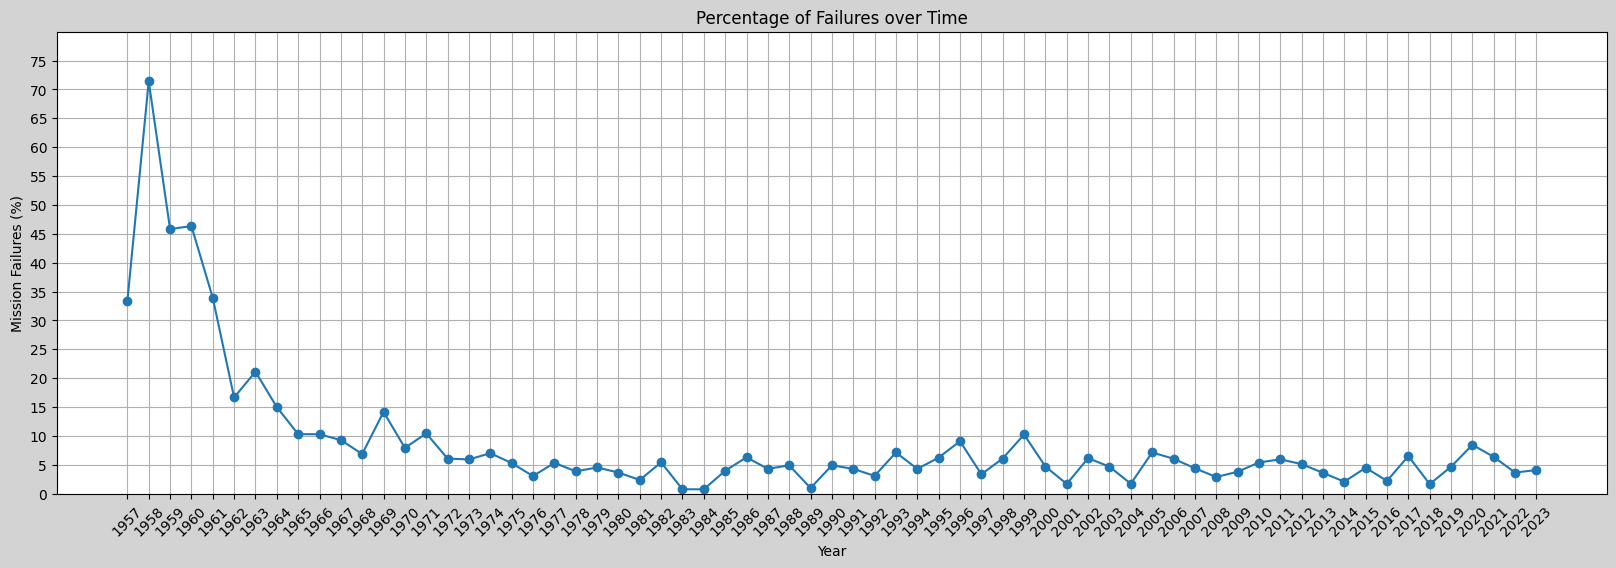

In [218]:
plt.figure(figsize=(20, 6), facecolor='lightgray')
plt.plot(mission_failures_year_on_year_percentage['Year'], mission_failures_year_on_year_percentage['Percentage'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Mission Failures (%)')
plt.title('Percentage of Failures over Time')
plt.xticks(mission_failures_year_on_year_percentage['Year'], rotation=45)
plt.ylim(0, 80)
plt.yticks(range(0, 80, 5))
plt.grid(True)
plt.show()

# For Every Year Show which Country was in the Lead in terms of Total Number of Launches up to and including including 2020)

Do the results change if we only look at the number of successful launches?

In [219]:
top_country_per_year = df_data.groupby([df_data['Datetime'].dt.year.rename('Year'), 'Country', 'Mission_status']).size().reset_index(name='Launch Count')
top_country_launches_per_year = top_country_per_year.groupby(['Year', 'Country'])['Launch Count'].sum().reset_index(name='Launch Count')
top_country_launches_per_year = top_country_launches_per_year.loc[top_country_launches_per_year.groupby('Year')['Launch Count'].idxmax()]

fig = px.bar(top_country_launches_per_year, x="Year", y="Launch Count", color='Country', title='Lead Country in Total Launches')
fig.update_xaxes(dtick=1)
fig.show()

In [220]:
top_country_successful_launches_per_year = top_country_per_year[top_country_per_year['Mission_status'] == 'Success']
top_country_successful_launches_per_year = top_country_successful_launches_per_year.loc[top_country_successful_launches_per_year.groupby('Year')['Launch Count'].idxmax()]

fig = px.bar(top_country_successful_launches_per_year, x="Year", y="Launch Count", color='Country', title='Lead Country in Successful Launches')
fig.update_xaxes(dtick=1)
fig.show()

# Create a Year-on-Year Chart Showing the Organisation Doing the Most Number of Launches

Which organisation was dominant in the 1970s and 1980s? Which organisation was dominant in 2018, 2019 and 2020?

In [221]:
organization_lead_launch = df_data.groupby([df_data['Datetime'].dt.year.rename('Year'), 'Organization']).size().reset_index(name='Launch Count')
organization_lead_launch = organization_lead_launch.loc[organization_lead_launch.groupby('Year')['Launch Count'].idxmax()]

fig = px.bar(organization_lead_launch, x="Year", y="Launch Count", color='Organization', title='Lead Organization in Total Launches')
fig.update_xaxes(dtick=1)
fig.show()